In [ ]:
!pip install kagglehub


In [ ]:
import kagglehub
import os
import shutil
import random


dataset_path = kagglehub.dataset_download("pevogam/ucf101")
print("✅ Dataset downloaded at:", dataset_path)


100%|██████████| 6.49G/6.49G [03:50<00:00, 30.2MB/s]

Extracting files...


✅ Dataset downloaded at: /root/.cache/kagglehub/datasets/pevogam/ucf101/versions/1


In [ ]:
import os
import shutil
import random


SOURCE_DIR = "/root/.cache/kagglehub/datasets/pevogam/ucf101/versions/1/UCF101/UCF-101"
DEST_DIR = "./UCF101_subset"
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

os.makedirs(DEST_DIR, exist_ok=True)

for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)
    os.makedirs(dest_class_path, exist_ok=True)

    # Get list of all .avi files
    videos = [f for f in os.listdir(class_path) if f.endswith('.avi')]
    selected = random.sample(videos, VIDEOS_PER_CLASS)

    for video in selected:
        shutil.copy(os.path.join(class_path, video), dest_class_path)

print("✅ Subset created at:", DEST_DIR)


✅ Subset created at: ./UCF101_subset


In [ ]:
import cv2
import numpy as np

# Parameters
FRAME_SIZE = (112, 112)  # (224, 224)
SEQ_LENGTH = 16
EXTRACT_EVERY = 5

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % EXTRACT_EVERY == 0:
            frame = cv2.resize(frame, FRAME_SIZE)
            frames.append(frame)
        frame_idx += 1

    cap.release()


    while len(frames) < SEQ_LENGTH:
        frames.append(frames[-1])

    return np.array(frames[:SEQ_LENGTH])


In [ ]:
from sklearn.preprocessing import LabelEncoder
import os
from tqdm import tqdm


SOURCE_DIR = "./UCF101_subset"
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

def load_dataset(dataset_path):
    X, y = [], []
    classes = sorted(os.listdir(dataset_path))

    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        for video in tqdm(os.listdir(class_path), desc=cls):
            video_path = os.path.join(class_path, video)
            frames = extract_frames(video_path)
            X.append(frames)
            y.append(cls)

    X = np.array(X)


    le = LabelEncoder()
    y = le.fit_transform(y)

    return X, y, le


In [ ]:
from sklearn.model_selection import train_test_split

# Load and preprocess the data
X, y, le = load_dataset(SOURCE_DIR)

# Split the data into 80/20 for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Typing: 100%|██████████| 10/10 [00:00<00:00, 16.73it/s]


Train samples: 40, Test samples: 10


In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        LSTM(64),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense

def build_3dcnn_model(input_shape, num_classes):
    model = Sequential([
        Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D((2, 2, 2)),
        Conv3D(64, (3, 3, 3), activation='relu'),
        GlobalAveragePooling3D(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# input shape for CNN-LSTM or 3D CNN
SEQ_LENGTH = 16
FRAME_SIZE = (112, 112)
input_shape = (SEQ_LENGTH, *FRAME_SIZE, 3)

num_classes = len(le.classes_)

# CNN-LSTM or 3D CNN
model = build_cnn_lstm_model(input_shape, num_classes)
# model = build_3dcnn_model(input_shape, num_classes)  # for 3D CNN

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 8s/step - accuracy: 0.2958 - loss: 1.5989 - val_accuracy: 0.3000 - val_loss: 1.6223
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 9s/step - accuracy: 0.1762 - loss: 1.6361 - val_accuracy: 0.2000 - val_loss: 1.6241
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 140s 8s/step - accuracy: 0.1396 - loss: 1.6498 - val_accuracy: 0.2000 - val_loss: 1.6136
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.0966 - loss: 1.6280 - val_accuracy: 0.2000 - val_loss: 1.6101
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 139s 8s/step - accuracy: 0.1254 - loss: 1.6159 - val_accuracy: 0.2000 - val_loss: 1.6098
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.0924 - loss: 1.6197 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 136s 8s/step - accuracy: 0.2402 - loss: 1.6110 - val_accuracy: 0.2000 - val_loss: 1.6097
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.2202 - loss: 1.6091 - val_accuracy: 0.2000 - val_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

   Basketball       0.00      0.00      0.00         2
       Biking       0.00      0.00      0.00         2
     JumpRope       0.00      0.00      0.00         2
PlayingGuitar       0.20      1.00      0.33         2
       Typing       0.00      0.00      0.00         2

     accuracy                           0.20        10
    macro avg       0.04      0.20      0.07        10
 weighted avg       0.04      0.20      0.07        10



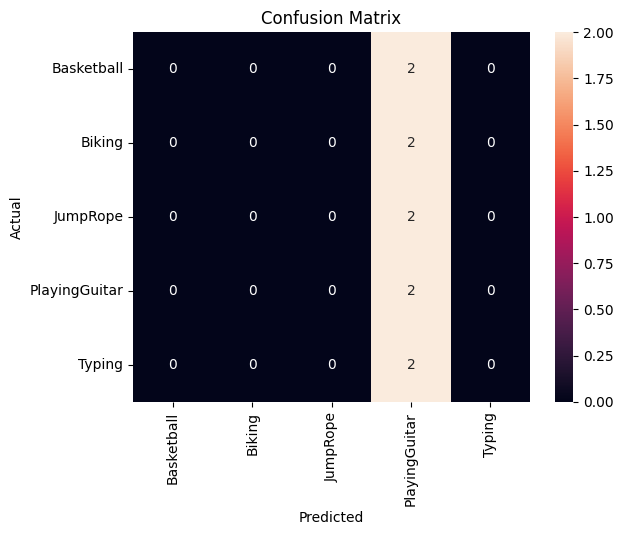

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = np.argmax(model.predict(X_test), axis=1)


print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
